In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import joblib
import os

In [3]:
torch.manual_seed(42)
os.makedirs("models", exist_ok=True)

In [4]:
DATA_PATH = "archive/dataset_sdn.csv"
df = pd.read_csv(DATA_PATH)

In [5]:
# Clean and preprocess
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
columns_to_drop = ['src', 'dst', 'Protocol']
df.drop(columns=[c for c in columns_to_drop if c in df.columns], inplace=True)

In [7]:
df['label'].value_counts()

0    61022
1    37726
Name: label, dtype: int64

In [44]:
df.to_csv('processed.csv')

In [8]:
label_col = "label"
num_cols = [c for c in df.columns if c != label_col]

In [9]:
num_cols

['dt',
 'switch',
 'pktcount',
 'bytecount',
 'dur',
 'dur_nsec',
 'tot_dur',
 'flows',
 'packetins',
 'pktperflow',
 'byteperflow',
 'pktrate',
 'Pairflow',
 'port_no',
 'tx_bytes',
 'rx_bytes',
 'tx_kbps',
 'rx_kbps',
 'tot_kbps']

In [11]:
X = df.drop(["label"],axis =1)
y = df["label"]

In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=5)
X_res, y_res = sm.fit_resample(X, y)

In [14]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_res)
y = y_res.values

In [15]:
joblib.dump(scaler, "models/minmax_scaler.pkl")

['models/minmax_scaler.pkl']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

In [18]:
input_dim = X_train.shape[1]

# First Layer Model

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, hidden_size)
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = F.relu(self.fc(out))
        return out

In [20]:
class LinearSVM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.fc(x)

# Second Layer Model

In [21]:
class CNNBiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, out_dim=128, dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bigru = nn.GRU(32, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_embed = nn.Linear(hidden_dim * 2, out_dim)
        self.fc_out = nn.Linear(out_dim, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        cnn_out = F.relu(self.cnn(x))
        rnn_out, _ = self.bigru(cnn_out.permute(0, 2, 1))
        emb = self.dropout(F.relu(self.fc_embed(rnn_out[:, -1, :])))
        out = self.fc_out(emb)
        return emb, out

In [22]:
hinge_loss = lambda logits, labels: torch.mean(torch.clamp(1 - logits.view(-1) * (2*labels - 1), min=0))
contrastive_loss = lambda z1, z2, y: torch.mean(y * torch.sum((z1 - z2)**2, dim=1) + (1 - y) * torch.clamp(1 - torch.sum((z1 - z2)**2, dim=1), min=0))

In [23]:
lstm = LSTMModel(input_dim)
svm = LinearSVM(128)
cnn = CNNBiGRU(input_dim)

In [24]:
opt_lstm = torch.optim.Adam(list(lstm.parameters()) + list(svm.parameters()), lr=0.001)
opt_cnn  = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [25]:
# Split for 3 clients
clients = []
split_size = len(X_train)//3
for i in range(3):
    start, end = i*split_size, (i+1)*split_size
    clients.append((X_train[start:end], y_train[start:end]))

In [28]:
EPOCHS_PER_CLIENT = 5
ROUNDS = 20

In [29]:
for round_idx in range(ROUNDS):
    print(f"\n Federated Round {round_idx+1}")
    
    local_lstm_states, local_cnn_states = [], []
    
    for client_idx, (Xc, yc) in enumerate(clients):
        print(f"  Training Client {client_idx+1}")
        for epoch in range(EPOCHS_PER_CLIENT):
            
            # --- LSTM + SVM ---
            opt_lstm.zero_grad()
            emb = lstm(Xc)
            logits1 = svm(emb)
            loss1 = hinge_loss(logits1, yc)
            loss1.backward()
            opt_lstm.step()
            
            # --- CNN + BiGRU + Contrastive ---
            opt_cnn.zero_grad()
            emb2, logits2 = cnn(Xc)
            bce_loss = F.binary_cross_entropy_with_logits(logits2.view(-1), yc)
            
            idx = torch.randperm(len(emb2))
            contrast = contrastive_loss(emb.detach(), emb2[idx], (yc == yc[idx]).float())
            
            total_loss = bce_loss + 0.5 * contrast
            total_loss.backward()
            opt_cnn.step()
        
        # Store local states
        local_lstm_states.append({k: v.cpu().clone() for k, v in lstm.state_dict().items()})
        local_cnn_states.append({k: v.cpu().clone() for k, v in cnn.state_dict().items()})
    
    # Federated averaging
    with torch.no_grad():
        for key in lstm.state_dict().keys():
            lstm.state_dict()[key].copy_(torch.stack([local_lstm_states[i][key] for i in range(len(clients))], dim=0).mean(dim=0))
        for key in cnn.state_dict().keys():
            cnn.state_dict()[key].copy_(torch.stack([local_cnn_states[i][key] for i in range(len(clients))], dim=0).mean(dim=0))
    
    # Evaluate each round
    lstm.eval(), svm.eval(), cnn.eval()
    with torch.no_grad():
        emb_test = lstm(X_test)
        y_pred1 = torch.sign(svm(emb_test).view(-1)).numpy()
        y_pred1 = (y_pred1 > 0).astype(int)
        emb2_test, logits2_test = cnn(X_test)
        y_pred2 = (torch.sigmoid(logits2_test.view(-1)) > 0.5).int().numpy()
    
    acc1 = accuracy_score(y_test, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    print(f"  Round {round_idx+1} Accuracies -> LSTM+SVM: {acc1:.4f}, CNN+BiGRU: {acc2:.4f}")


 Federated Round 1
  Training Client 1
  Training Client 2
  Training Client 3
  Round 1 Accuracies -> LSTM+SVM: 0.6820, CNN+BiGRU: 0.5486

 Federated Round 2
  Training Client 1
  Training Client 2
  Training Client 3
  Round 2 Accuracies -> LSTM+SVM: 0.7235, CNN+BiGRU: 0.6098

 Federated Round 3
  Training Client 1
  Training Client 2
  Training Client 3
  Round 3 Accuracies -> LSTM+SVM: 0.7332, CNN+BiGRU: 0.6505

 Federated Round 4
  Training Client 1
  Training Client 2
  Training Client 3
  Round 4 Accuracies -> LSTM+SVM: 0.7329, CNN+BiGRU: 0.6906

 Federated Round 5
  Training Client 1
  Training Client 2
  Training Client 3
  Round 5 Accuracies -> LSTM+SVM: 0.7368, CNN+BiGRU: 0.7136

 Federated Round 6
  Training Client 1
  Training Client 2
  Training Client 3
  Round 6 Accuracies -> LSTM+SVM: 0.7428, CNN+BiGRU: 0.7244

 Federated Round 7
  Training Client 1
  Training Client 2
  Training Client 3
  Round 7 Accuracies -> LSTM+SVM: 0.7482, CNN+BiGRU: 0.7350

 Federated Round 8


In [30]:
lstm.eval()

LSTMModel(
  (lstm): LSTM(19, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=128, bias=True)
)

In [31]:
svm.eval()

LinearSVM(
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [32]:
cnn.eval()

CNNBiGRU(
  (cnn): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bigru): GRU(32, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_embed): Linear(in_features=256, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
with torch.no_grad():
    emb_test = lstm(X_test)
    y_pred1 = (torch.sign(svm(emb_test).view(-1)) > 0).int().numpy()
    emb2_test, logits2_test = cnn(X_test)
    y_pred2 = (torch.sigmoid(logits2_test.view(-1)) > 0.5).int().numpy()

In [34]:
metrics = {
    "LSTM_SVM_Accuracy": accuracy_score(y_test, y_pred1),
    "LSTM_SVM_Recall": recall_score(y_test, y_pred1),
    "LSTM_SVM_Precision" : precision_score(y_test, y_pred1),
    "LSTM_SVM_F1" : f1_score(y_test, y_pred1),
    "CNN_BiGRU_Accuracy": accuracy_score(y_test, y_pred2),
    "CNN_BiGRU_Recall": recall_score(y_test, y_pred2),
    "CNN_BiGRU_Precision": precision_score(y_test, y_pred2),
    "CNN_BiGRU_F1": f1_score(y_test, y_pred2)
}

df_metrics = pd.DataFrame([metrics])

In [37]:
summary_df = pd.DataFrame({
    "Model": ["LSTM+SVM-1st Layer", "CNN+BiGRU-2nd Layer"],
    "Accuracy": [metrics["LSTM_SVM_Accuracy"], metrics["CNN_BiGRU_Accuracy"]],
    "Recall": [metrics["LSTM_SVM_Recall"], metrics["CNN_BiGRU_Recall"]],
    "Precision": [metrics["LSTM_SVM_Precision"], metrics["CNN_BiGRU_Precision"]],
    "F1": [metrics["LSTM_SVM_F1"], metrics["CNN_BiGRU_F1"]]
})

In [38]:
summary_df

,Model,Accuracy,Recall,Precision,F1
0,LSTM+SVM-1st Layer,0.872506,0.931181,0.833407,0.879585
1,CNN+BiGRU-2nd Layer,0.826662,0.858266,0.807274,0.831990


In [36]:
joblib.dump(lstm.state_dict(), "models/lstm_svm_fed_model.pkl")
joblib.dump(cnn.state_dict(), "models/cnn_bigru_fed_model.pkl")

['models/cnn_bigru_fed_model.pkl']

# Graph

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

df_metrics = pd.DataFrame(summary_df)

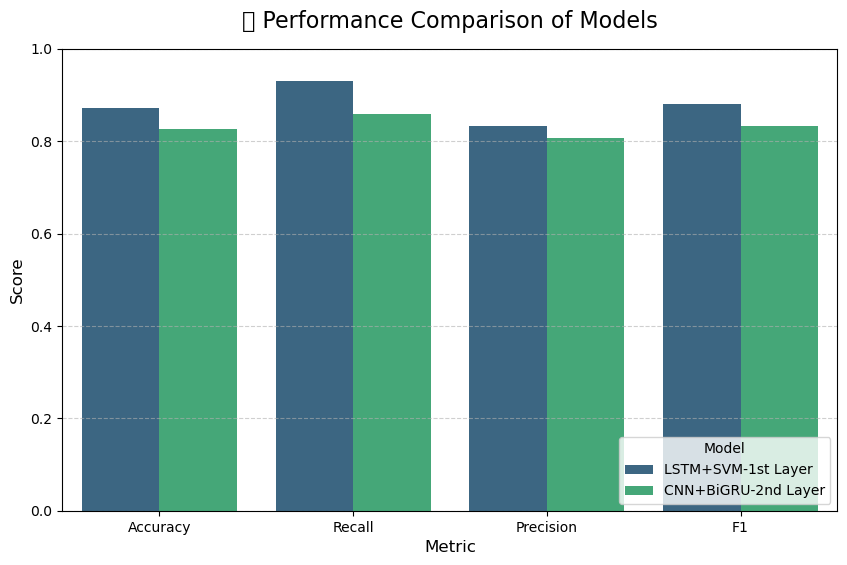

In [43]:
# Melt the DataFrame for seaborn plotting
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set up the plot
plt.figure(figsize=(10,6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="viridis")

# Customize
plt.title("📈 Performance Comparison of Models", fontsize=16, pad=15)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Model", loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()